In [1]:
"""Test module for explanation ai implemented with LIME"""
# Add module path for demo.
# Todo: make wheel file -> setup file -> pip install tsx-**.whl
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from keras.models import load_model
from tsx.perturbation import TimeSeriesPerturbation
from tsx.xai.lime import LIMETimeSeries

WORK_DIR = ".."
NOTEBOOK_DIR = "."
DATA_DIR = f"{NOTEBOOK_DIR}/data"
assert os.path.exists(DATA_DIR), f"Not found folder {DATA_DIR}"
assert os.path.exists(WORK_DIR), f"Not found folder {WORK_DIR}"
assert os.path.exists(NOTEBOOK_DIR), f"Not found folder {NOTEBOOK_DIR}"

Using TensorFlow backend.


## Prepare Data Set

In [3]:
def preload_uts(data_dir=DATA_DIR):
    df = pd.read_csv(f"{data_dir}/climate_small.csv")
    with open(f"{data_dir}/climate_small_schema.json") as f:
        schema = json.load(f)
        df = df.astype(schema)

    df = df.set_index("measure_date")
    tmk = df.query("stations_id == 2074")["tmk"]

    input_steps = 32
    return tmk[-input_steps:].to_numpy()

In [4]:
model = load_model(f"{DATA_DIR}/uts_tmk_32_1.h5")
def predict_fn(x, *args):
    x = x.reshape(1, -1, 1)

    y_hat = model.predict(x, *args)

    # flatten to one value, this depends on the model
    return y_hat.ravel().item()

[ 0.  0. -0.  0. -0.  0. -0.  0.]
[ 0.  0. -0.  0. -0.  0. -0.  0.]
[ 0.  0. -0.  0. -0.  0. -0.  0.]


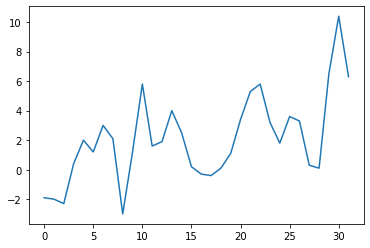

In [12]:
import matplotlib.pyplot as plt

ts_original = preload_uts()
plt.plot(ts_original)

ts_lime_zero = LIMETimeSeries(window_size=4, sample_size=1000, perturb_method='zeros')
ts_lime_local_mean = LIMETimeSeries(window_size=4, sample_size=1000, perturb_method='local_mean')
ts_lime_global_mean = LIMETimeSeries(window_size=4, sample_size=1000, perturb_method='global_mean')

ts_lime_zero.explain(ts_original.reshape(1, -1), predict_fn=predict_fn)
ts_lime_local_mean.explain(ts_original.reshape(1, -1), predict_fn=predict_fn)
ts_lime_global_mean.explain(ts_original.reshape(1, -1), predict_fn=predict_fn)

print(ts_lime_zero.coef)
print(ts_lime_local_mean.coef)
print(ts_lime_global_mean.coef)

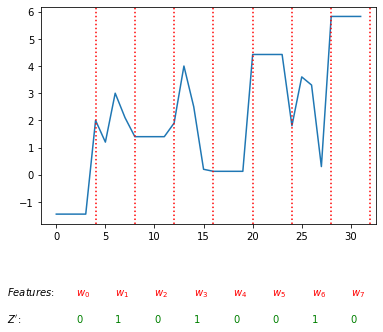

In [20]:
def viz_local_sample(xai=None):
    z_prime, z_original, z_hat, sample_weight = xai.get_a_local_sample()

    if len(z_prime) == 1:
        # univariate
        # Normalize data from shape (n_features, n_steps) -> uts: (, nsteps)
        z_prime = z_prime.ravel()
        z_original = z_original.ravel()
    window_size = xai.window_size
    n_segments = xai.n_segments

    # Z
    fig, ax = plt.subplots()
    ax.plot(z_original)

    # Segments + Z'
    w_text_y = min(z_original) - 3   
    z_text_y = w_text_y - 1
    ax.text(-5, w_text_y, r"$Features$: ")
    ax.text(-5, z_text_y, r"$Z'$: ")
    for i in range(n_segments):
        p_x = window_size * (i + 1)
        ax.axvline(x=p_x, c='r', ls=':')
        text_x = p_x - (window_size / 2) # center
        
        ax.text(text_x, w_text_y, r"$w_{%i}$" % i, c='r')
        ax.text(text_x, z_text_y, z_prime[i], c='g')
    return fig, ax

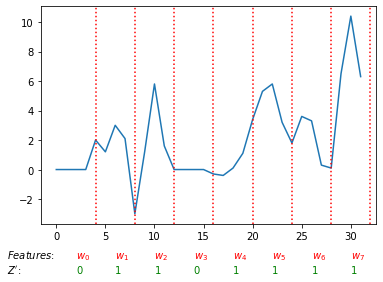

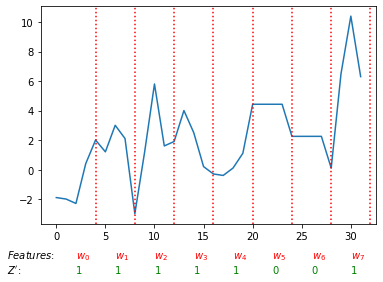

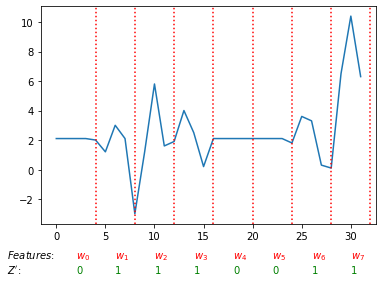

In [24]:
# Todo create same z_prime -> to_original_form(z_prime)

fig_1, ax_1 = viz_local_sample(ts_lime_zero)
fig_2, ax_2 = viz_local_sample(ts_lime_local_mean)
fig_3, ax_3 = viz_local_sample(ts_lime_global_mean)